In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from dask.distributed import Client
import distributed

from condor_utils import make_htcondor_cluster
from dask.distributed import Client, progress
#from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler

import utils
import glob
import uproot4
import awkward1 as ak
from yahist import Hist1D
from yahist import Hist2D

import matplotlib.pyplot as plt

#import uproot_methods

utils.bokeh_output_notebook()

Loading BokehJS ...

In [2]:
cluster = make_htcondor_cluster(local=False, dashboard_address=13349)
cluster

In [3]:
cluster.scale(200)

In [ ]:
c = Client(cluster)
c

In [ ]:
c.restart()

In [ ]:
#client.shutdown()

In [5]:
def initialize_arraycache():
    from distributed import get_worker
    import uproot
    worker = get_worker()
    worker.cache = uproot.ArrayCache("6 GB")
    worker.treecache = {}
    
c.run(initialize_arraycache);

In [6]:
def cachesize_metric():
    def f(worker):
        if hasattr(worker,"cache"):
            return "{:.2f}GB".format(worker.cache._cache.currsize/1e9)
        return 0
    return f

def treecache_metric():
    def f(worker):
        if hasattr(worker,"treecache"):
            return len(list(worker.treecache.keys()))
        return 0
    return f

def register_metrics(dask_worker):
    dask_worker.metrics["cachesize"] = cachesize_metric()
    dask_worker.metrics["treecache"] = treecache_metric()

c.run(register_metrics);

In [7]:
%%time
futures = c.map(lambda x:x, range(100),pure=False)
np.array(c.gather(futures)).shape

CPU times: user 81.4 ms, sys: 12.8 ms, total: 94.2 ms
Wall time: 161 ms


(100,)

In [8]:
%%time
fnames = sorted(glob.glob("/hadoop/cms/store/user/hmei/rawreco_runII/zerobias/ZeroBias_Run2018D-LogError-PromptReco-v2_RAW-RECO_v0.1_20201108/*root"))[:-1]
#fnames = sorted(glob.glob("/hadoop/cms/store/user/hmei/rawreco_runII/zerobias/ZeroBias_Run2018D-LogError-PromptReco-v2_RAW-RECO_v0.1_20201027/*root"))[:-1]
chunks, total_nevents = utils.get_chunking(tuple(fnames),int(2.0e3),treename="cscRootMaker/Events",skip_bad_files=True)
print("{} chunks of {} files, with a total of {:.5g} events".format(len(chunks),len(fnames),total_nevents))

#import csv
#import ast
#with open('chunklist_2018D_zerobias.csv', newline='') as f:
#    reader = csv.reader(f)
#    chunks = list(reader)
#
#chunks = [ast.literal_eval(i) for i in chunks[0]]
#chunks


2724 chunks of 324 files, with a total of 5.0995e+06 events
CPU times: user 5.02 s, sys: 1.29 s, total: 6.31 s
Wall time: 1min 36s


In [ ]:
#fnames = sorted(glob.glob("/hadoop/cms/store/user/hmei/rawreco_runII/zerobias/ZeroBias_Run2018D-LogError-PromptReco-v2_RAW-RECO_v0.1_20201103/*root"))[:-1]
#def getChunks(fnames):
#    #fnames = sorted(glob.glob("/hadoop/cms/store/user/hmei/rawreco_runII/zerobias/ZeroBias_Run2018D-LogError-PromptReco-v2_RAW-RECO_v0.1_20201103/*root"))[:-1]
#    chunks, total_nevents = utils.get_chunking(tuple(fnames),int(2.0e3),treename="cscRootMaker/Events")
#    return chunks
#
#futures = []
#fname_cnt = 0
#step = 5 
#for i in range(len(fnames)//step):
#    future = c.submit(getChunks, fnames[fname_cnt:min(fname_cnt+step, len(fnames))])#, pure=False)
#    futures.append(future)
#    fname_cnt += step
#    
#results = c.gather(futures)

In [18]:
#c.retire_workers(workers=["tcp://169.228.130.149:38370"])
#' 
#    tcp://169.228.130.148:36250' 
c.restart()
#c.get_worker_logs()
#c.processing().items()
#def f():
#    import subprocess
#    return subprocess.getoutput("grep ProcId $_CONDOR_JOB_AD")
#c.run(f)

Client Scheduler: tcp://169.228.130.37:11030 Dashboard: http://169.228.130.37:13349/status,Cluster Workers: 98 Cores: 98 Memory: 196.00 GB


In [11]:
#import csv
#with open("chunklist_2018D_zerobias.csv", 'w', newline='') as myfile:
#     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#     wr.writerow(chunks)

In [110]:
%%time
def gethist(args):
    fname,entrystart,entrystop = args
    try:
        from distributed import get_worker
        worker = get_worker()
        # array cache
        cache = worker.cache
        # also cache the tree object (otherwise opening file+getting tree is ~0.7s overhead)
        if fname in worker.treecache:
            t = worker.treecache[fname]
        else:
            f = uproot4.open(fname)
            t = f["cscRootMaker/Events"]
            worker.treecache[fname] = t
    except:
        cache = None
        f = uproot4.open(fname)
        t = f["cscRootMaker/Events"]
        
    rh_keys = t.keys(filter_name="recHits2D_*")
    rhcoll = t.arrays(rh_keys, library="ak", how="zip") 
    mask_station = [rhcoll.recHits2D.ID_station == i for i in range(1,5)]
    mask_ring = [rhcoll.recHits2D.ID_ring == i for i in range(1,5)]
    comb_s_r = [(1,1), (1,2), (1,3), (1,4), (2,1), (2,2), (3,1), (3,2), (4,1), (4,2)]
    mask_chamberID = [ mask_station[c_[0]-1] & mask_ring[c_[1]-1] for c_ in comb_s_r ]
    
    #mask_belongsToMuon = rhcoll.recHits2D.belongsToMuon
    #bin_btm = np.linspace(-2,2,5)
    #hist_btm = Hist1D(np.array( ak.flatten(mask_belongsToMuon) ), bins=bin_btm)
    ##
    #localYYerr = rhcoll.recHits2D.localYYerr/rhcoll.recHits2D.localY
    #bin_yerr = np.linspace(0,0.1,100)
    #hist_yerr = Hist1D(np.array(ak.flatten(localYYerr) ), bins=bin_yerr)

    #localXXerr = abs(rhcoll.recHits2D.localXXerr)/rhcoll.recHits2D.localX
    localXXerr = rhcoll.recHits2D.localXXerr
    bin_xerr = np.linspace(0,0.01,100)
    hist_xerr = Hist1D(np.array(ak.flatten(localXXerr) ), bins=bin_xerr)
    
    #mask_yerr = rhcoll.recHits2D.localYYerr < 2
    mask_xerr = rhcoll.recHits2D.localXXerr < 0.01 
    
    localx = [ ak.flatten(rhcoll.recHits2D.localX[mask_ & mask_xerr]) for mask_ in mask_chamberID]
    localy = [ ak.flatten(rhcoll.recHits2D.localY[mask_ & mask_xerr]) for mask_ in mask_chamberID]

    bin_localx = np.linspace(-100,100,101)
    bin_localy = np.linspace(-200,200,81)
    hists_localxy = [ Hist2D(np.c_[ak.to_numpy(localx[i]), ak.to_numpy(localy[i])], bins=[bin_localx, bin_localy],
                           label="station " + str(comb_s_r[i][0]) + " ring " + str(comb_s_r[i][1]) ) for i in range(len(comb_s_r)) ]
    return hists_localxy
    #return hists_localxy, hist_btm, hist_yerr, hist_xerr

x = gethist((chunks[9][0],chunks[9][1],chunks[9][2]//20))
#x,h1,h2,h3 = gethist((chunks[9][0],chunks[9][1],chunks[9][2]//20))

CPU times: user 3.33 s, sys: 493 ms, total: 3.82 s
Wall time: 3.77 s


In [108]:
h3

[ 0.00 ± 0.00   2694.00 ± 51.90   7433.00 ± 86.21   8305.00 ± 91.13
 13686.00 ± 116.99   16452.00 ± 128.27   15368.00 ± 123.97
 14130.00 ± 118.87   13296.00 ± 115.31   13525.00 ± 116.30
 15757.00 ± 125.53   15448.00 ± 124.29   14753.00 ± 121.46
 13899.00 ± 117.89   13588.00 ± 116.57   12472.00 ± 111.68
 12386.00 ± 111.29   11330.00 ± 106.44   11733.00 ± 108.32
 11132.00 ± 105.51   11509.00 ± 107.28   9784.00 ± 98.91
 10767.00 ± 103.76   9934.00 ± 99.67   8632.00 ± 92.91   9851.00 ± 99.25
 9022.00 ± 94.98   8716.00 ± 93.36   7767.00 ± 88.13   9340.00 ± 96.64
 9256.00 ± 96.21   7442.00 ± 86.27   7968.00 ± 89.26   8401.00 ± 91.66
 7578.00 ± 87.05   6862.00 ± 82.84   7026.00 ± 83.82   7755.00 ± 88.06
 7098.00 ± 84.25   5724.00 ± 75.66   7413.00 ± 86.10   6820.00 ± 82.58
 6101.00 ± 78.11   6260.00 ± 79.12   7170.00 ± 84.68   6226.00 ± 78.91
 5396.00 ± 73.46   6679.00 ± 81.73   6033.00 ± 77.67   5787.00 ± 76.07
 6005.00 ± 77.49   5384.00 ± 73.38   4809.00 ± 69.35   6203.00 ± 78.76
 5974.00 ± 77.29   5447.00 ± 73.80   4586.00 ± 67.72   4753.00 ± 68.94
 5609.00 ± 74.89   4948.00 ± 70.34   5255.00 ± 72.49   4657.00 ± 68.24
 3975.00 ± 63.05   3416.00 ± 58.45   4823.00 ± 69.45   4272.00 ± 65.36
 3563.00 ± 59.69   2931.00 ± 54.14   3030.00 ± 55.05   3159.00 ± 56.20
 3080.00 ± 55.50   2937.00 ± 54.19   2765.00 ± 52.58   2766.00 ± 52.59
 2781.00 ± 52.74   2459.00 ± 49.59   2152.00 ± 46.39   2137.00 ± 46.23
 2189.00 ± 46.79   2176.00 ± 46.65   1865.00 ± 43.19   1599.00 ± 39.99
 1738.00 ± 41.69   1658.00 ± 40.72   1404.00 ± 37.47   1265.00 ± 35.57
 1144.00 ± 33.82   1115.00 ± 33.39   1051.00 ± 32.42   985.00 ± 31.38
 864.00 ± 29.39   836.00 ± 28.91   825.00 ± 28.72   740.00 ± 27.20
 749.00 ± 27.37   757.00 ± 27.51   683.00 ± 26.13   698.00 ± 26.42
 158628.00 ± 398.28]

In [112]:
%%time
futures = []
for chunk in chunks:
    future = c.submit(gethist, chunk)#, pure=False)
    futures.append(future)

results = c.gather(futures)
len(results)
#futures = c.map(get_hist,chunks[:500])#,pure=False)
#results = c.gather(futures)
#len(results)

CPU times: user 1min 55s, sys: 12.2 s, total: 2min 7s
Wall time: 11min 35s


316

[Text(0.5, 1.0, 'station 1 ring 1'),
 Text(0.5, 1.0, 'station 1 ring 2'),
 Text(0.5, 1.0, 'station 1 ring 3'),
 Text(0.5, 1.0, 'station 1 ring 4'),
 Text(0.5, 1.0, 'station 2 ring 1'),
 Text(0.5, 1.0, 'station 2 ring 2'),
 Text(0.5, 1.0, 'station 3 ring 1'),
 Text(0.5, 1.0, 'station 3 ring 2'),
 Text(0.5, 1.0, 'station 4 ring 1'),
 Text(0.5, 1.0, 'station 4 ring 2')]

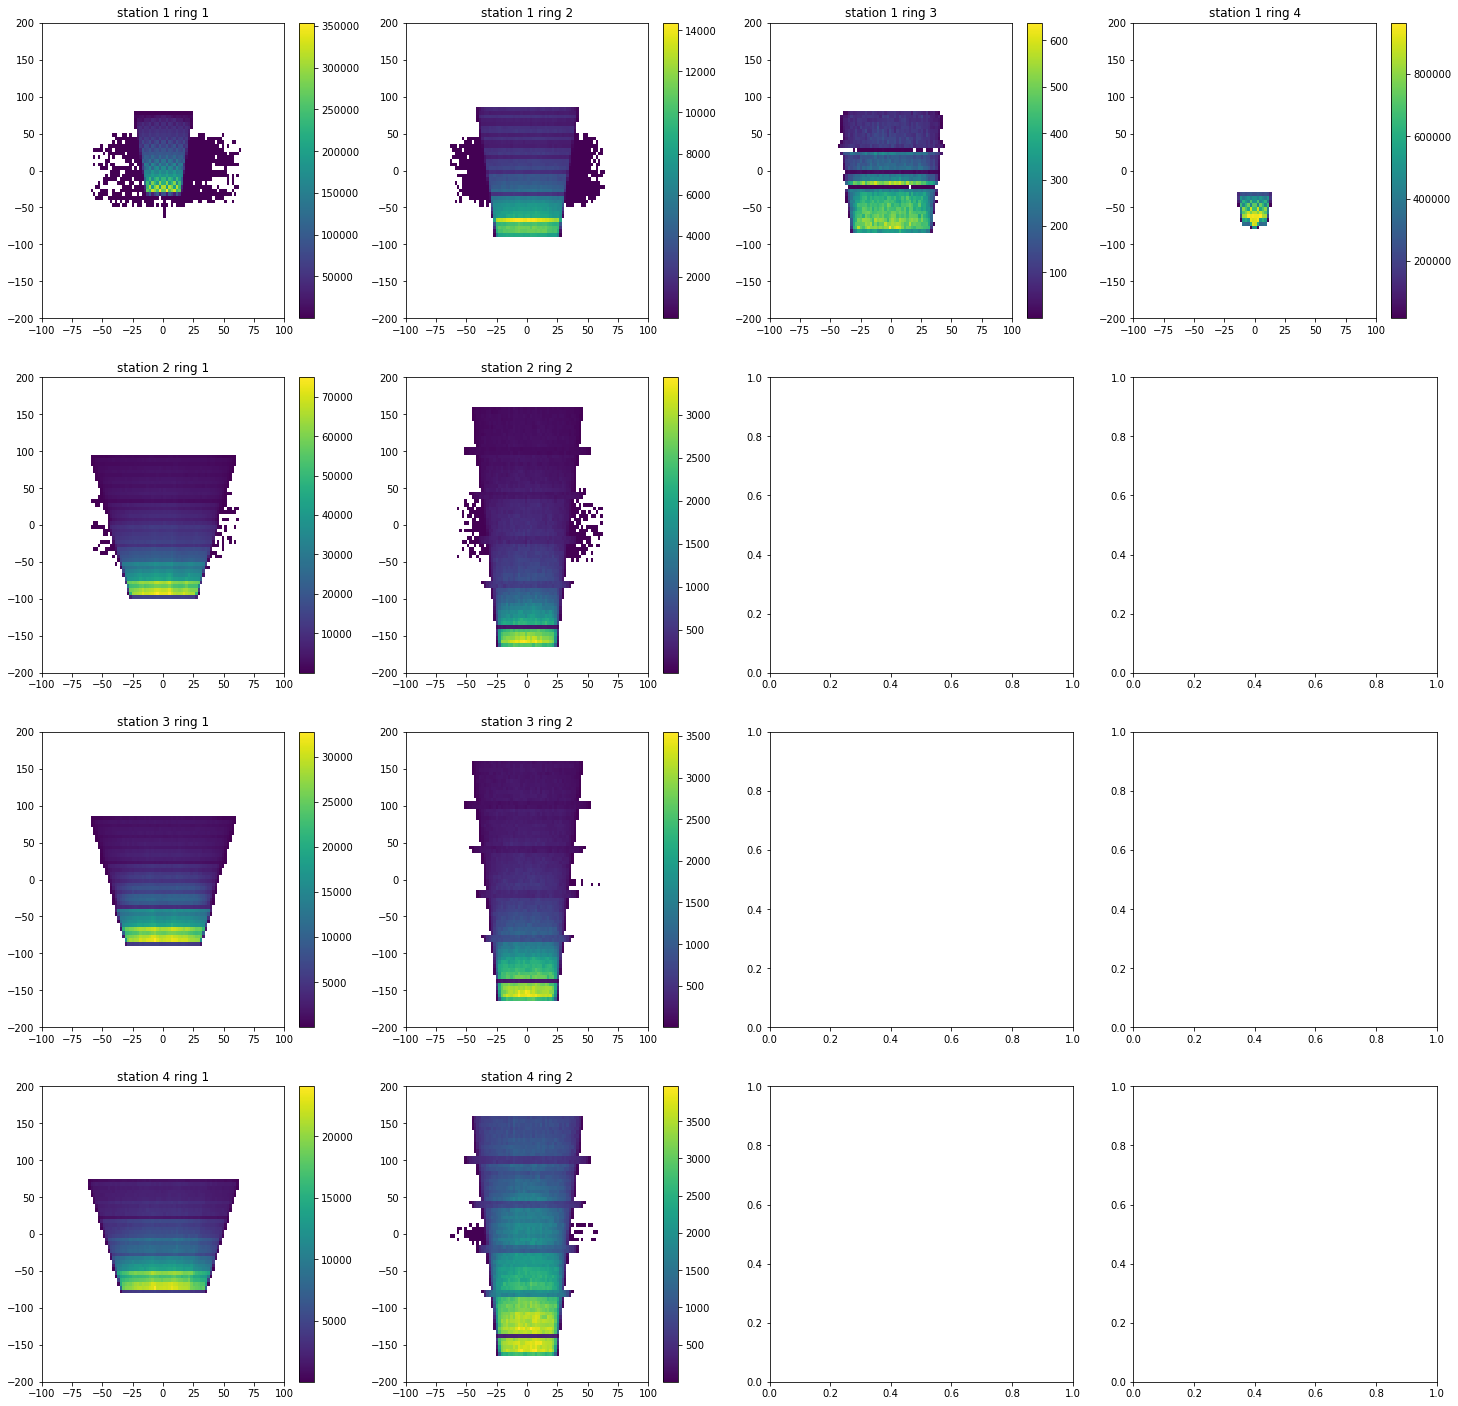

In [114]:
#np.sum( np.array(results)[:,3] )
comb_s_r = [(1,1), (1,2), (1,3), (1,4), (2,1), (2,2), (3,1), (3,2), (4,1), (4,2)]

merged_hist_localxy = [np.sum(np.array(results)[:,i]) for i in range(len(results[0]))]

figxy, axsxy = plt.subplots(4,4, figsize=(25,25))

[merged_hist_localxy[i].plot(axsxy[comb_s_r[i][0]-1][comb_s_r[i][1]-1]) for i in range(len(comb_s_r))]

[axsxy[comb_s_r[i][0]-1][comb_s_r[i][1]-1].set_title("station " + str(comb_s_r[i][0]) + " ring " + str(comb_s_r[i][1])) for i in range(len(comb_s_r))]

### get effective area of each chamber type

In [132]:
## these area are wrong, see picture above
merged_hist_localxy[0]._counts
areas = [np.count_nonzero(merged_hist_localxy[i]._counts)/8000.0*(200*400) for i in range(len(merged_hist_localxy))]
areas

[12200.0,
 17520.0,
 13560.000000000002,
 1260.0,
 19380.0,
 32890.0,
 16870.0,
 32300.0,
 15500.0,
 32420.0]

tornado.application - ERROR - Uncaught exception GET /status/ws (::1)
HTTPServerRequest(protocol='http', host='localhost:13349', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='::1')
Traceback (most recent call last):
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/tornado/websocket.py", line 954, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/tornado/web.py", line 3173, in wrapper
    return method(self, *args, **kwargs)
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/bokeh/server/views/ws.py", line 137, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: Token is expired.


### do something in chamber without muon

In [13]:
import numba as nb

In [19]:
@nb.jit
def doCSC(events):
    ''' 
    keys_tosave = ["Event", "Run", "LumiSect", 
                   "muons_cscSegmentRecord_endcap", 
                   "muons_cscSegmentRecord_station",
                   "muons_cscSegmentRecord_ring", 
                   "muons_cscSegmentRecord_chamber",
                   "muons_nMuons"
                  ]
    '''
    
    # get total number of rechits in this tree
    nrh_tot = 0
    for event in events:
        nrh_tot += event.recHits2D_nRecHits2D
        
    # run,evt,lumi,endcap,station,ring,chamber,inCSCHasMu
    cscHasRH = np.zeros((nrh_tot, 8), dtype=np.int64) 
    
    nrh_cnt = np.int64(0)
    
    for event in events:
        evt_id = np.array([event.Run, event.Event, event.LumiSect])
        
        # get number of chambers associated with muons in this event
        nseg_evt = 0
        nmu_evt = len(event.muons_cscSegmentRecord_endcap)
        for i in range(nmu_evt):
            ncscseg = len(event.muons_cscSegmentRecord_endcap[i])
            nseg_evt += ncscseg
            
        # save all csc id with muon segment
        csc_hasMu_evt = np.zeros((nseg_evt,4), dtype=np.int64)
        nseg_evt2 = 0
        for i in range(nmu_evt):
            ncscseg = len(event.muons_cscSegmentRecord_endcap[i])
            if ncscseg <= 0: continue
            for j in range(ncscseg):
                csc_hasMu_evt[nseg_evt2] = np.array([ event.muons_cscSegmentRecord_endcap[i][j],
                                                      event.muons_cscSegmentRecord_station[i][j],
                                                      event.muons_cscSegmentRecord_ring[i][j],
                                                      event.muons_cscSegmentRecord_chamber[i][j] ])
                nseg_evt2 += 1
            
        rechits = event.recHits2D
        for rh in rechits: 
            csc_id = np.array([rh.ID_endcap, rh.ID_station, rh.ID_ring, rh.ID_chamber])
            evt_csc_id = np.append(evt_id, csc_id)
            csc_found = False 
            # check if this csc has muon
            for csc_id_mu in csc_hasMu_evt:
                if np.array_equal(csc_id, csc_id_mu):
                    csc_found = True
                    break
            cscHasRH[nrh_cnt] = np.append(evt_csc_id, np.array([np.int64(csc_found)])) 
            nrh_cnt += 1
            
    return cscHasRH


### get lumi

In [7]:
#import csv
df_lumi = pd.read_csv("/hadoop/cms/store/user/hmei/lumi/output_byls_2018ABCD_hzub_clean.csv") 

### do all csc

In [56]:
%%time
lumifile = "/hadoop/cms/store/user/hmei/lumi/output_byls_2018ABCD_hzub.csv"
def getLumi(run, lumisect, lumifile):
    import subprocess
    #grep 315252 /hadoop/cms/store/user/hmei/lumi/output_byls_2018ABCD_hzub.csv | grep ",5:" | awk -F "," '{print $7}'
    #command = " grep \"" + str(run) + ":\" " + lumifile + "| grep \"," + str(lumisect) + ":\" | awk -F \",\" '{print $7}' "
    command = " grep " + str(run) + " "  + lumifile + "| grep \"," + str(lumisect)+ ":\" | awk -F \",\" '{print $7}' "
    tmpLumi = (subprocess.Popen(command,stdout=subprocess.PIPE,shell=True) ).communicate()[0]
    lumi = tmpLumi.decode("utf-8").strip('\n')
    return lumi


getLumi(315252, 5, lumifile)

CPU times: user 54.3 ms, sys: 38.7 ms, total: 93 ms
Wall time: 456 ms


'4361.948024352'

In [13]:
%%time
def doCSCAll(args):
    
    df_lumi_path = "/hadoop/cms/store/user/hmei/lumi/output_byls_2018ABCD_hzub_clean.csv"
    
    fname,entrystart,entrystop = args
    try:
        from distributed import get_worker
        worker = get_worker()
        # array cache
        cache = worker.cache
        # also cache the tree object (otherwise opening file+getting tree is ~0.7s overhead)
        if fname in worker.treecache:
            t = worker.treecache[fname]
        else:
            f = uproot4.open(fname)
            t = f["cscRootMaker/Events"]
            worker.treecache[fname] = t
    except:
        cache = None
        f = uproot4.open(fname)
        t = f["cscRootMaker/Events"]
    #f = uproot4.open(fname)
    #t = f["cscRootMaker/Events"]
        
    nmuon = t.arrays("muons_nMuons", library="ak", how="zip",entry_start=entrystart, entry_stop=entrystop)
    #nmuon = t.arrays("muons_nMuons", library="ak", how="zip")
    if (ak.sum(nmuon) <= 0):
        # in some root files, there is one event with no muon, which gives problem when using ak, probably due to the muon_cscSegmentRecord...
        #return np.zeros((len(nmuon), 8), dtype=np.int64) 
        return 0 #np.zeros((len(nmuon), 8), dtype=np.int64) 
        
    
    keys_tosave = ["Event", "Run", "LumiSect"]
    events = t.arrays( keys_tosave + t.keys(filter_name="recHits2D_*") + t.keys(filter_name="muons_*"),
                       entry_start=entrystart, entry_stop=entrystop, library="ak", how="zip")
    #events = t.arrays( keys_tosave + t.keys(filter_name="recHits2D_*") + t.keys(filter_name="muons_*"),
    #                   library="ak", how="zip")
    ## get nevts with muon/without muon
    #mask_noMuon = (events.muons_nMuons == 0)
    #nevts = len(events)
    #nevts_noMuon = len(events[mask_noMuon])
    #print ("nEvts total: ", nevts, ", nEvts without muon: ", nevts_noMuon)

    ## get nevts with/without muon-csc segment
    ## mask_muCSCSeg = (events.muons.numberOfSegments > 0)
    ## need to use this instead of numberOfSegments is due to a bug in ntuplizer 
    ## if there is no csc mu segment, numberOfSegments will inherit last event
    museg_endcap = events.muons_cscSegmentRecord_endcap
    mask_noMuCSCSeg = ak.sum( ak.sum(museg_endcap, axis=2) , axis=1) == 0
    #nmucscseg = ak.num(events.muons[mask_muCSCSeg])
    evts_noMuCSCSeg = events[mask_noMuCSCSeg]
    #unique_elements, counts_elements = np.unique(ak.to_numpy(nmucscseg), return_counts=True)
    ##print ("nmucscseg in evt", unique_elements)
    #float_formatter = "{:.2f}".format
    #np.set_printoptions(formatter={'float_kind':float_formatter})
    #print ("fraction of evt", counts_elements/nevts*100 )
    
    ncsc_per_type = {"1_1": 36, "1_2": 36, "1_3": 36, "1_4": 36,
                     "2_1": 18, "3_1": 18, "4_1": 18,
                     "2_2": 36, "3_2": 36, "4_2": 36}
    
    masks_endcap = [evts_noMuCSCSeg.recHits2D.ID_endcap == i for i in range(1,3)]
    masks_station = [evts_noMuCSCSeg.recHits2D.ID_station == i for i in range(1,5)]
    masks_ring = [evts_noMuCSCSeg.recHits2D.ID_ring == i for i in range(1,5)]
    masks_chamber = [evts_noMuCSCSeg.recHits2D.ID_chamber == i for i in range(1,37)]
    
    # get all cscID (e,s,r,c) combination
    cscID_comb = []
    for endcap in range(1,3):
        for station in range(1,5):
            for ring in range(1,5):
                if station > 1 and ring > 2: continue
                for chamber in range(1, ncsc_per_type[str(station) + "_" + str(ring)]+1):
                                     cscID_comb.append((endcap, station, ring, chamber))

    masks_cscID = [ masks_endcap[c_[0]-1] & masks_station[c_[1]-1] & masks_ring[c_[2]-1] & masks_chamber[c_[3]-1] for c_ in cscID_comb]
    
    df_lumi = pd.read_csv(df_lumi_path) 
    evt_runs = evts_noMuCSCSeg.Run
    evt_lumisects = evts_noMuCSCSeg.LumiSect
    lumi = [df_lumi.loc[ (df_lumi["run"] == evt_runs[i]) & 
                         (df_lumi["lumisect"] == evt_lumisects[i] ) ]["deliver"].to_numpy()
            for i in range(len(evts_noMuCSCSeg))]
    ## this is protect against missing lumi in json file
    ## 1000 is to change to 1e33
    lumi_array = np.array([l[0]/1000.0 if len(l) == 1 else -1 for l in lumi])
    #print (lumi_array)
    evts_noMuCSCSeg.InstLumi = ak.Array(lumi_array)
    
    ## free up some memory
    del df_lumi
    
    rhs_per_csc = evts_noMuCSCSeg.recHits2D
    # per-event, per-cscID
    nrhs_allCSC = [ ak.num( rhs_per_csc[mask] ) for mask in masks_cscID ]
    lumi_allCSC = [ evts_noMuCSCSeg.InstLumi for mask in masks_cscID]
    
    nrh_clean = [ ak.to_numpy(nrhs_allCSC[i][nrhs_allCSC[i] > 0]) for i in range(len(nrhs_allCSC))] 
    lumi_clean = [ ak.to_numpy(lumi_allCSC[i][nrhs_allCSC[i] > 0]) for i in range(len(nrhs_allCSC))] 
    #print (nrh_vs_lumi)
    
    #bin_nrh = np.linspace(0,50,51)
    #bin_lumi = np.linspace(0,25,26)
 #
    #hists_nrh_lumi = [ Hist2D(np.c_[lumi_clean[i], nrh_clean[i]], bins=[bin_lumi, bin_nrh]) for i in range(len(cscID_comb))]
    #hists_nrh_lumi = []
    #return hists_nrh_lumi
    return nrh_clean, lumi_clean

index = 19 
#allHists = doCSCAll((chunks[index][0],chunks[index][1],chunks[index][2]))
rh,lumi = doCSCAll((chunks[index][0],chunks[index][1],chunks[index][2]))
#for i in range(19,20):
#    print (i)
#    allHists = doCSCAll((chunks[i][0],chunks[i][1],chunks[i]//20))

CPU times: user 12.8 s, sys: 657 ms, total: 13.5 s
Wall time: 19.7 s


In [16]:
#def doCSCChunk(chunks):
#    rh_all, lumi
#    for chunk in chunks:
#        doCSCAll(chunk)

[array([16.2713768 , 16.24128693, 15.5972576 , 15.58286161, 15.53248492,
        15.53248492, 10.93721123, 10.93721123, 10.27625457,  9.4365644 ,
         9.4365644 ,  9.4365644 ,  9.24496913,  9.23418068,  9.22770781,
         9.12916643,  8.34694693,  8.45659708,  8.86875441]),
 array([16.56878811, 16.2713768 , 16.2713768 , 16.2713768 , 16.25387915,
        16.25387915, 15.66101656, 15.58286161, 15.58286161, 15.53248492,
        15.53248492, 10.96714485, 10.93721123, 10.93721123, 10.27625457,
        10.27022507, 10.19698141, 10.13534654, 10.12914028,  9.4365644 ,
         9.27578266,  9.22770781,  9.12916643,  9.12916643,  8.34694693,
         8.87207385,  8.96834269,  8.88464361]),
 array([16.553813  , 16.2713768 , 16.2713768 , 16.25387915, 16.25387915,
        16.25387915, 16.25387915, 16.24128693, 15.67154426, 15.644558  ,
        15.5972576 , 15.5972576 , 15.5972576 , 15.58286161, 15.58286161,
        15.53248492, 10.93721123, 10.27022507, 10.11227253, 10.12914028,
         9.43

In [39]:
c.shutdown()

In [33]:
%%time
lumi_path="/hadoop/cms/store/user/hmei/lumi/output_byls_2018ABCD_hzub_clean.csv"
futures = []
for chunk in chunks:
    future = c.submit(doCSCAll, chunk)#, pure=False)
    futures.append(future)

#results = c.gather(futures)
#len(results)


CPU times: user 2.04 s, sys: 200 ms, total: 2.24 s
Wall time: 1.95 s


In [34]:
from dask.distributed import progress

progress(futures)

VBox()

In [15]:
results = c.gather(futures)

In [16]:
len(results)

2805

In [20]:
ncsc_per_type = {"1_1": 36, "1_2": 36, "1_3": 36, "1_4": 36,
                 "2_1": 18, "3_1": 18, "4_1": 18,
                 "2_2": 36, "3_2": 36, "4_2": 36}
cscID_comb = []
for endcap in range(1,3):
    for station in range(1,5):
        for ring in range(1,5):
            if station > 1 and ring > 2: continue
            for chamber in range(1, ncsc_per_type[str(station) + "_" + str(ring)]+1):
                                 cscID_comb.append((endcap, station, ring, chamber))
                    
len(cscID_comb)

612

In [35]:
ncsc_per_type = {"1_1": 36, "1_2": 36, "1_3": 36, "1_4": 36,
                 "2_1": 18, "3_1": 18, "4_1": 18,
                 "2_2": 36, "3_2": 36, "4_2": 36}
cscID_comb = []
for endcap in range(1,3):
    for station in range(1,5):
        for ring in range(1,5):
            if station > 1 and ring > 2: continue
            for chamber in range(1, ncsc_per_type[str(station) + "_" + str(ring)]+1):
                                 cscID_comb.append((endcap, station, ring, chamber))
                    
bin_nrh = np.linspace(0,50,51)
bin_lumi = np.linspace(0,25,26)
hists_nrh_lumi = [ Hist2D(np.c_[np.array([]), np.array([])], bins=[bin_lumi, bin_nrh]) for i in range(len(cscID_comb))]
                    
## to be understood how to use, but seems a very efficient tool
from dask.distributed import as_completed

#futures,results = as_completed(futures, with_results=True)
# a global histogram

counter = 0
for future, result in as_completed(futures, with_results=True):
    # a local histogram
    if type(result) == int: continue 
    nrh_tmp = result[0] 
    lumi_tmp = result[1]
    hist_local = [ Hist2D(np.c_[nrh_tmp[i], lumi_tmp[i]], bins=[bin_lumi, bin_nrh]) for i in range(len(cscID_comb))]
    # update global histogram
    for i in range(len(hists_nrh_lumi)):
        hists_nrh_lumi[i] += hist_local[i] 
    print (counter)
    counter += 1
    

/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
Task exception was never retrieved
future: <Task finished name='Task-725912' coro=<connect.<locals>._() done, defined at /home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/comm/core.py:288> exception=CommClosedError()>
Traceback (most recent call last):
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/comm/tcp.py", line 241, in write
    stream.write(b)
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/tornado/iostream.py", line 531, in write
    self._check_closed()
  Fi

0


distributed.scheduler - ERROR - Couldn't gather keys {'doCSCAll-939b943576925a348d6c7362b61baafc': ['tcp://169.228.131.251:35431'], 'doCSCAll-01629626ac7d22347f5a517198a97f47': ['tcp://169.228.131.251:35431'], 'doCSCAll-b59172121397ba66960c987fa4fad45a': ['tcp://169.228.131.251:35431'], 'doCSCAll-ea6d4f55672b45fc847ad202cb734c59': ['tcp://169.228.131.251:35431']} state: ['memory', 'memory', 'memory', 'memory'] workers: ['tcp://169.228.131.251:35431']
NoneType: None
Task exception was never retrieved
future: <Task finished name='Task-726712' coro=<connect.<locals>._() done, defined at /home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/comm/core.py:288> exception=CommClosedError()>
Traceback (most recent call last):
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/comm/tcp.py", line 241, in write
    stream.write(b)
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/tornado/iostrea

1
2
3
4
5
6
7
8


Task exception was never retrieved
future: <Task finished name='Task-726866' coro=<connect.<locals>._() done, defined at /home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/comm/core.py:288> exception=CommClosedError()>
Traceback (most recent call last):
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/comm/tcp.py", line 241, in write
    stream.write(b)
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/tornado/iostream.py", line 531, in write
    self._check_closed()
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/tornado/iostream.py", line 1017, in _check_closed
    raise StreamClosedError(real_error=self.error)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packag

9
10
11


/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://169.228.131.94:38542'], doCSCAll-79a70908e7894000e0aa9e2322198617
NoneType: None


12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52


/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


53


/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
distributed.scheduler - ERROR - Couldn't gather keys {'doCSCAll-f582f18285f6dba275b4ebbbf1d45452': ['tcp://169.228.132.124:35199'], 'doCSCAll-e79eb45cabe311b76770cd22dbe6d5cb': []} state: ['memory', 'processing'] workers: ['tcp://169.228.132.124:35199']
NoneType: None


54


distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://169.228.132.124:35199'], doCSCAll-f582f18285f6dba275b4ebbbf1d45452
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], doCSCAll-e79eb45cabe311b76770cd22dbe6d5cb
NoneType: None


55
56
57


distributed.scheduler - ERROR - Couldn't gather keys {'doCSCAll-3a680a9ddab34a438fa07f663af946ce': []} state: ['processing'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], doCSCAll-3a680a9ddab34a438fa07f663af946ce
NoneType: None


58
59
60
61


distributed.scheduler - ERROR - Couldn't gather keys {'doCSCAll-6009519a82b5349d412ad6f14246c3af': ['tcp://169.228.130.151:39749'], 'doCSCAll-0be29fe32c504b4dd081b9fcdca43f20': ['tcp://169.228.130.151:38104'], 'doCSCAll-39230b9005a386368c9ce7d76c1b0181': []} state: ['memory', 'memory', 'memory'] workers: ['tcp://169.228.130.151:39749', 'tcp://169.228.130.151:38104']
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {'doCSCAll-35eca4ccc3aa2e5525530d2404551c59': ['tcp://169.228.131.250:41253']} state: ['memory'] workers: ['tcp://169.228.131.250:41253']
NoneType: None
/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=or

62


distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://169.228.130.151:39749'], doCSCAll-6009519a82b5349d412ad6f14246c3af
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://169.228.130.151:38104'], doCSCAll-0be29fe32c504b4dd081b9fcdca43f20
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], doCSCAll-39230b9005a386368c9ce7d76c1b0181
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://169.228.131.250:41253'], doCSCAll-35eca4ccc3aa2e5525530d2404551c59
NoneType: None


63
64


distributed.core - ERROR - 'tcp://169.228.130.151:39749'
Traceback (most recent call last):
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/core.py", line 597, in handle_stream
    handler(**merge(extra, msg))
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/scheduler.py", line 2684, in handle_release_data
    ws = self.workers[worker]
KeyError: 'tcp://169.228.130.151:39749'
distributed.utils - ERROR - 'tcp://169.228.130.151:39749'
Traceback (most recent call last):
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/utils.py", line 655, in log_errors
    yield
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/scheduler.py", line 1813, in add_worker
    await self.handle_worker(comm=comm, worker=address)
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/scheduler.py", line 

65
66
67
68
69
70
71
72


distributed.core - ERROR - 'tcp://169.228.130.151:38104'
Traceback (most recent call last):
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/core.py", line 597, in handle_stream
    handler(**merge(extra, msg))
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/scheduler.py", line 2684, in handle_release_data
    ws = self.workers[worker]
KeyError: 'tcp://169.228.130.151:38104'
distributed.utils - ERROR - 'tcp://169.228.130.151:38104'
Traceback (most recent call last):
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/utils.py", line 655, in log_errors
    yield
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/scheduler.py", line 1813, in add_worker
    await self.handle_worker(comm=comm, worker=address)
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/scheduler.py", line 

73


distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://169.228.131.50:40401'], doCSCAll-d0d933ff62d3efa83f8ef796b83db702
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://169.228.131.68:34263'], doCSCAll-9ff21ec39769093c9b5fdcafb05762ca
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://169.228.132.168:21680'], doCSCAll-ae20494e48b1f3b8f1d7928231aa98c9
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://169.228.132.104:34817'], doCSCAll-c8dc0f334abcd1eea54284a9a9397d6e
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://169.228.131.219:41328'], doCSCAll-c2fcaf8ee7d7685cfe1bf931bbc132e1
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://169.228.131.251:34651'], doCSCAll-f0b89e8336424a812c84fdc224a81880
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp:/

74


distributed.scheduler - ERROR - Couldn't gather keys {'doCSCAll-583da7f1e9055a069393d2dde024857d': [], 'doCSCAll-f5528eaa45cc2c69bc3e3fcc13540c87': [], 'doCSCAll-46a891605bb8c60bd2f642448b98ea61': [], 'doCSCAll-d0c1a44d85a946333edd9c0876c5a05a': [], 'doCSCAll-286d711358da321e4495096cbe47ce9d': [], 'doCSCAll-bc7c33209c3fed161bde6ce6b0e49ec9': [], 'doCSCAll-5e2f0b92861029bc59e68489b6e2344d': [], 'doCSCAll-6baa33beba2c67a3d9c58716d9a2d599': [], 'doCSCAll-62842c880e2dbb33306dd9dbab0c5beb': [], 'doCSCAll-2fb98e7918746b6a4dac5e0206e14b17': [], 'doCSCAll-c2be9d6785eab3b7a34f92ec14c43c5c': [], 'doCSCAll-ea6fb346ef61ec753c080a03a9b222d5': [], 'doCSCAll-51eae31a2d5e37f8f6e64f20e2d5a70d': [], 'doCSCAll-dc78ffdd72593949e8c54194d5223933': [], 'doCSCAll-7d14a5417e59fefb4936cea47281ed3b': [], 'doCSCAll-8a53c888edc8cd67eabf9be6662624a0': [], 'doCSCAll-26f05f02640b3e17144582f93cd3bbdd': [], 'doCSCAll-3e162670cb94dfd1a2337d8eab9218da': [], 'doCSCAll-79dddca2bb0057cb7b515adb01d8cdd4': [], 'doCSCAll-faf09

75


tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f36ed5086a0>>, <Task finished name='Task-721459' coro=<as_completed._track_future() done, defined at /home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/client.py:4389> exception=KilledWorker('doCSCAll-27181447c19cdd4d65e94a857ed0d36c', <Worker 'tcp://169.228.131.248:45270', name: 166, memory: 0, processing: 45>)>)
Traceback (most recent call last):
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/tornado/ioloop.py", line 765, in _discard_future_result
    future.result()
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/client.py", line 4396, in _track_future
    result = a

76


distributed.scheduler - ERROR - Workers don't have promised key: [], doCSCAll-644ea9e5cf39657fc70938c361c75108
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], doCSCAll-f582f18285f6dba275b4ebbbf1d45452
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], doCSCAll-3cc36988427a0d32fc0df801e3d9ac06
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], doCSCAll-4521daf8bd3cca4ef370df4dce22aef2
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], doCSCAll-ba3525946bc523cbcf1b3445bca221d9
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], doCSCAll-ed4d11103244de617b458d96cc1d2365
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], doCSCAll-b4785745a2a46b2ad91758882d09d428
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], doCSCAll-f0d6fecf96cb7987e3a321cda7855b29
NoneTyp

77
78
79
80
81


/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequ

82


/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequ

83


/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequ

84


/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequ

85


/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


86
87
88
89
90
91


Task exception was never retrieved
future: <Task finished name='Task-731900' coro=<connect.<locals>._() done, defined at /home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/comm/core.py:288> exception=CommClosedError()>
Traceback (most recent call last):
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/comm/tcp.py", line 241, in write
    stream.write(b)
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/tornado/iostream.py", line 531, in write
    self._check_closed()
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/tornado/iostream.py", line 1017, in _check_closed
    raise StreamClosedError(real_error=self.error)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packag

92


distributed.scheduler - ERROR - Couldn't gather keys {'doCSCAll-b23a1843884d740617e4243a507be270': [], 'doCSCAll-3193761614f01bc6c612b9fb8b6ff04e': [], 'doCSCAll-7e6944fabc60dd317b0181f63dd754b2': [], 'doCSCAll-67fe8c9484aa98a9f051ac57332f4185': [], 'doCSCAll-f6041a290826f64f46b18e413abfbb6f': [], 'doCSCAll-02c24f543c753a773f9314dd24a86182': [], 'doCSCAll-149d61e6e16b77185313dff341ebabef': [], 'doCSCAll-e3b76415741cd9f33dd9c20dbb73ad8e': ['tcp://169.228.132.168:11410'], 'doCSCAll-f57401951074a761209e306770c579d1': [], 'doCSCAll-19572850cc1c604c64c02c24c777ae2a': [], 'doCSCAll-433cf52547e739fa4977741bd7ed32d8': [], 'doCSCAll-9d989cdf78f61a5cb4328291910fb597': [], 'doCSCAll-e31fb88310549014ae85500dea2a42a8': [], 'doCSCAll-a6106a2daa66f445535bcdaa88b472f2': [], 'doCSCAll-7d9b0ebbd7bb0b9ff456338c62e193ab': [], 'doCSCAll-ec0ae60966f9b4fc3e350330aeb9cad5': ['tcp://169.228.132.102:37889'], 'doCSCAll-b60bade33d688e5930ef69c9fe38b8dc': [], 'doCSCAll-6a3b2d96b9e06edd4719f003a326a249': [], 'doCSC

93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112


distributed.core - ERROR - 'tcp://169.228.132.122:35342'
Traceback (most recent call last):
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/core.py", line 597, in handle_stream
    handler(**merge(extra, msg))
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/scheduler.py", line 2684, in handle_release_data
    ws = self.workers[worker]
KeyError: 'tcp://169.228.132.122:35342'
distributed.utils - ERROR - 'tcp://169.228.132.122:35342'
Traceback (most recent call last):
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/utils.py", line 655, in log_errors
    yield
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/scheduler.py", line 1813, in add_worker
    await self.handle_worker(comm=comm, worker=address)
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/scheduler.py", line 

113
114
115


distributed.core - ERROR - 'tcp://169.228.132.106:39949'
Traceback (most recent call last):
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/core.py", line 597, in handle_stream
    handler(**merge(extra, msg))
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/scheduler.py", line 2684, in handle_release_data
    ws = self.workers[worker]
KeyError: 'tcp://169.228.132.106:39949'
distributed.utils - ERROR - 'tcp://169.228.132.106:39949'
Traceback (most recent call last):
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/utils.py", line 655, in log_errors
    yield
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/scheduler.py", line 1813, in add_worker
    await self.handle_worker(comm=comm, worker=address)
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/scheduler.py", line 

116


distributed.scheduler - ERROR - Workers don't have promised key: [], doCSCAll-1e022aceb555ddca668e917ecf43c34e
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], doCSCAll-4ad8a60a3fa1f67499030aab7ece7a1d
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], doCSCAll-d1aab13135141b11bb243f7301cfb21f
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], doCSCAll-e087447119f668e4716cf4f0722295df
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], doCSCAll-eeca001c0a316986cd1c510b755361db
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], doCSCAll-39e87a1ec1b3b91eb5fcd6a0c7451da2
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], doCSCAll-27ad55ce25d58015310eca307ca389fc
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], doCSCAll-d086179b058f5094aecf64cea085a5ba
NoneTyp

117
118
119
120
121
122


Task exception was never retrieved
future: <Task finished name='Task-735484' coro=<connect.<locals>._() done, defined at /home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/comm/core.py:288> exception=CommClosedError()>
Traceback (most recent call last):
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/distributed/comm/tcp.py", line 241, in write
    stream.write(b)
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/tornado/iostream.py", line 531, in write
    self._check_closed()
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/tornado/iostream.py", line 1017, in _check_closed
    raise StreamClosedError(real_error=self.error)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packag

123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176


KeyboardInterrupt: 

In [27]:
type(1)

int

In [72]:
c.retire_workers(workers=["tcp://169.228.131.121:32811"])

()

In [ ]:
## send task to workers who has run it before
d = c.who_has(futures)
workers = [set(d[f.key]) for f in futures]
futures = c.map(doCSCAll,chunks,workers=workers,pure=False)

In [11]:
len(results)

NameError: name 'results' is not defined

## test area

In [31]:
fname = chunks[0][0]

f = uproot4.open("/hadoop/cms/store/user/hmei/rawreco_runII/zerobias/ZeroBias_Run2018D-LogError-PromptReco-v2_RAW-RECO_v0.1_20201103/test_rawreco_21.root")
t = f["cscRootMaker/Events"]

keys_tosave = ["Event", "Run", "LumiSect" 
#           "muons_cscSegmentRecord_endcap", 
#           "muons_cscSegmentRecord_station",
#           "muons_cscSegmentRecord_ring", 
#           "muons_cscSegmentRecord_chamber",
#           "muons_nMuons"
          ]



In [41]:
%%time

events = t.arrays( keys_tosave + t.keys(filter_name="recHits2D_*") + t.keys(filter_name="muons_*"), library="ak", how="zip")
#museg_endcap = events_withmu.muons_cscSegmentRecord_endcap #[ (events_withmu.muons_nMuons > 0) ]


CPU times: user 3.58 s, sys: 434 ms, total: 4.01 s
Wall time: 3.51 s


In [51]:
## get nevts with muon/without muon
mask_noMuon = (events.muons_nMuons == 0)
nevts = len(events)
nevts_noMuon = len(events[mask_noMuon])
print ("nEvts total: ", nevts, ", nEvts without muon: ", nevts_noMuon)

## get nevts with/without muon-csc segment
mask_muCSCSeg = (events.muons.numberOfSegments > 0)
nmucscseg = ak.num(events.muons[mask_muCSCSeg])

unique_elements, counts_elements = np.unique(ak.to_numpy(nmucscseg), return_counts=True)
print ("nmucscseg in evt", unique_elements)
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
print ("fraction of evt", counts_elements/nevts*100 )

## estimate total number of chamber having rechits in this tree
mask_ME11 = (events.recHits2D.ID_station == 1) & (events.recHits2D.ID_station == 1) & \
            (events.recHits2D.ID_endcap == 1) & (events.recHits2D.ID_chamber == 16)

nME11 = ak.num(events.recHits2D[mask_ME11])
print (nME11, len(mask_ME11))
#print (nME11, ak.to_list(mask_ME11)[0])

nEvts total:  19102 , nEvts without muon:  1412
nmucscseg in evt [0 1 2 3 4]
fraction of evt [78.45 18.45 2.66 0.39 0.05]
[0, 0, 0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 19102


In [42]:
len(results[0])

184429

In [127]:
#c.retire_workers(workers=["tcp://169.228.132.133:35208"])
#c.retire_workers(workers=["tcp://169.228.130.147:43912"])
#c.retire_workers(workers=["tcp://169.228.131.228:42111"])
c.retire_workers(workers=["tcp://169.228.131.234:1145"])
#c.processing().items()
#def f():
#    import subprocess
#    return subprocess.getoutput("grep ProcId $_CONDOR_JOB_AD")
#c.run(f)

()